# Life-Cycle Labor Supply of Couples

Solves and simulates a $T$-period labor supply model with two-earner couples. <br>
**Motivated** by the study “Are Marriage-Related Taxes and Social Security Benefits Holding Back Female Labor Supply?” by Borella et al. (forthcoming). <br>
**Goal** is to replicate effects of individual vs. joint taxation.

For simplicity, couples cannot divorce nor save.

The **Bellman equation** and the recursive formulation of our simple model is 
$$
\begin{align*}
V_{t}(K_{1,t},K_{2,t}) & =\max_{h_{1,t},h_{2,t}}U(c_{t},h_{1,t},h_{2,t})+\beta V_{t+1}(K_{1,t+1},K_{2,t+1})\\
c_{t} & =\sum_{j=1}^{2}w_{j,t}h_{j,t}-T(w_{1,t}h_{1,t},w_{2,t}h_{2,t})\\
\log w_{j,t} & =\alpha_{j,0}+\alpha_{j,1}K_{j,t},\;j\in\{1,2\}\\
K_{j,t+1} & =(1-\delta)K_{j,t}+h_{j,t},\;j\in\{1,2\}
\end{align*}
$$

**Preferences** are sum of individuals
$$
U(c_{t},h_{1,t},h_{2,t})=2\frac{(c_{t}/2)^{1+\eta}}{1+\eta}-\rho_{1}\frac{h_{1,t}^{1+\gamma}}{1+\gamma}-\rho_{2}\frac{h_{2,t}^{1+\gamma}}{1+\gamma}
$$





**Taxes** are on the household level
$$
T(Y_{1},Y_{2})=(1-\lambda(Y_{1}+Y_{2})^{-\tau})\cdot(Y_{1}+Y_{2})
$$

**Terminal period:** There are no bequests such that
$$
V_{T}(K_{1,T},K_{2,T})  =\max_{h_{1,T},h_{2,T}}U(c_{T},h_{1,T},h_{2,T})
$$

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import numba as nb

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

from scipy.optimize import root_scalar

import pandas as pd

figpath = r"/Users/bruger/Desktop/HouseholdBehaviorCourse/06/Figures"


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# Question 1

In [37]:
from DynHouseholdLaborModel import DynHouseholdLaborModelClass
model = DynHouseholdLaborModelClass()

par = model.par
sol = model.sol
sim = model.sim

In [38]:
model.solve()

In [39]:
model1 = model.copy(par={'weight_u': True})
model2 = model.copy(par={'weight_u': False})
model3 = model.copy(par={'weight_u': True, 'mu': 0.2})

In [40]:
model1.solve()
model2.solve()
model3.solve()

In [41]:
model1.sim.k1_init = 2.0*np.ones(par.simN)
model1.simulate()
model2.sim.k1_init = 2.0*np.ones(par.simN)
model2.simulate()
model3.sim.k1_init = 2.0*np.ones(par.simN)
model3.simulate()

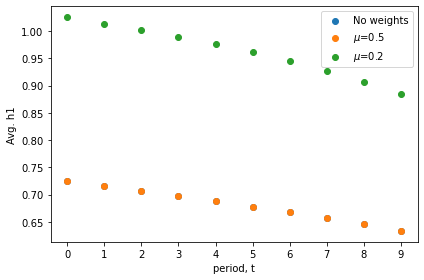

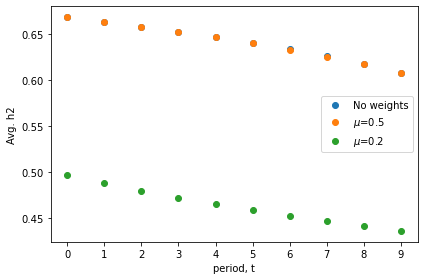

In [42]:
for var in ('h1','h2'):
    fig, ax = plt.subplots()
    ax.scatter(range(par.simT),np.mean(getattr(model2.sim,var),axis=0),label='No weights')
    ax.scatter(range(par.simT),np.mean(getattr(model1.sim,var),axis=0),label='$\mu$=0.5')
    ax.scatter(range(par.simT),np.mean(getattr(model3.sim,var),axis=0),label='$\mu$=0.2')
    ax.set(xlabel='period, t',ylabel=f'Avg. {var}',xticks=range(par.simT));
    ax.legend();
    fig.tight_layout();
    if var == 'h1':
        fig.savefig(figpath+ r"/no1h1.pdf",edgecolor='k')
    elif var == 'h2':
        fig.savefig(figpath+ r"/no1h2.pdf",edgecolor='k')

# Question 3

Policy Reform: move to individual taxation


This means that the household budget is now
$$
c_{t}  =\sum_{j=1}^{2}w_{j,t}h_{j,t}-T(w_{1,t}h_{1,t})-T(w_{2,t}h_{2,t})\\
$$

I implement this via the switch `par.joint_tax=False`.

In [43]:
# Initiate two models with the two different tax regimes
model3 = model.copy(par={'joint_tax': True})
model4 = model.copy(par={'joint_tax': False})

In [44]:
# Solve and simulate model. Initiate 
model3.solve()
model3.sim.k1_init = 2.0*np.ones(par.simN)
model3.simulate()

In [45]:
# Solve and simulate model with 1 pct. increase in male wage
model3_1 = model3.copy()
model3_1.par.wage_const_1 = np.log(np.exp(par.wage_const_1) * 1.01) # 1% increase in wage
model3_1.solve()
model3_1.sim.k1_init = 2.0*np.ones(par.simN)
model3_1.simulate()

In [46]:
model4.solve()
model4.sim.k1_init = 2.0*np.ones(par.simN)
model4.simulate()

In [47]:
model4_1 = model4.copy()
model4_1.par.wage_const_1 = np.log(np.exp(par.wage_const_1) * 1.01) # 1% increase in wage
model4_1.solve()
model4_1.sim.k1_init = 2.0*np.ones(par.simN)
model4_1.simulate()

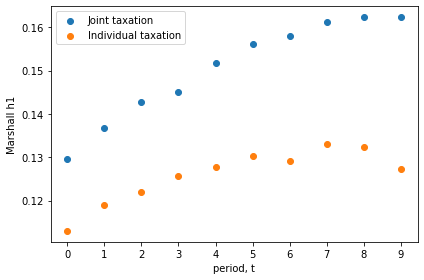

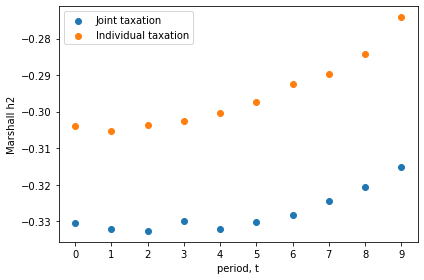

In [48]:
# Elasticities
for var in ('h1','h2'):
    fig, ax = plt.subplots()
    base3 = np.mean(getattr(model3.sim,var),axis=0)
    new3 = np.mean(getattr(model3_1.sim,var),axis=0)
    ela3 = (new3 - base3)/base3*100
    base4 = np.mean(getattr(model4.sim,var),axis=0)
    new4 = np.mean(getattr(model4_1.sim,var),axis=0)
    ela4 = (new4 - base4)/base4*100
    ax.scatter(range(par.simT),ela3,label='Joint taxation')
    ax.scatter(range(par.simT),ela4,label='Individual taxation')
    ax.set(xlabel='period, t',ylabel=f'Marshall {var}',xticks=range(par.simT));
    ax.legend();
    fig.tight_layout();
    if var == 'h1':
        fig.savefig(figpath+ r"/no2marshall1.pdf",edgecolor='k')
    elif var == 'h2':
        fig.savefig(figpath+ r"/no2marshall2.pdf",edgecolor='k')
    

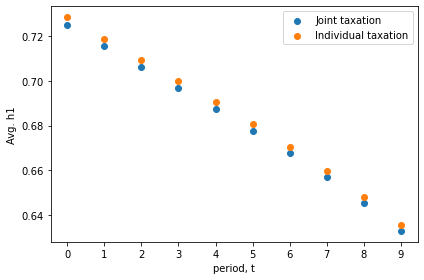

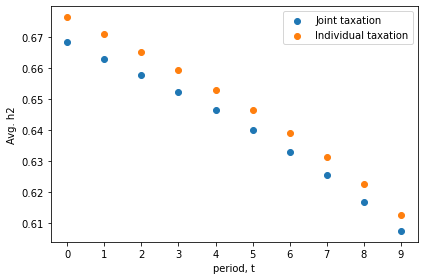

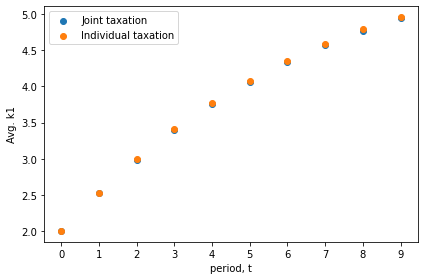

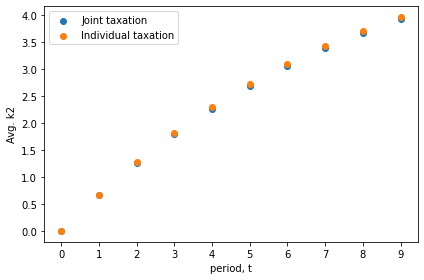

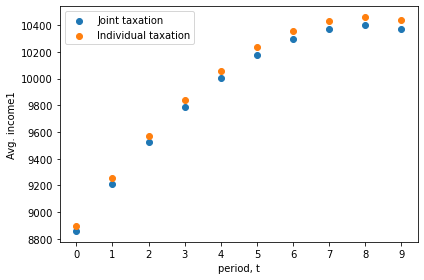

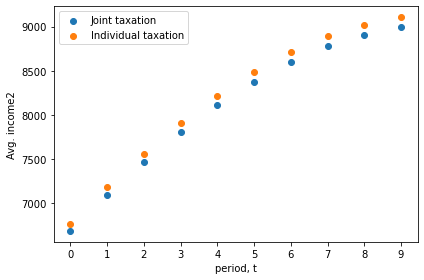

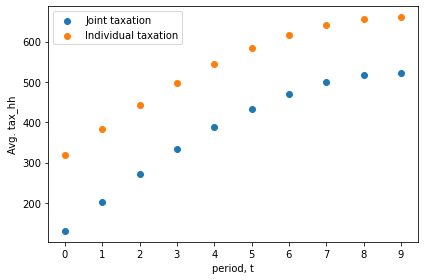

In [49]:
# plot behavior 
for var in ('h1','h2','k1','k2','income1','income2','tax_hh'):
    fig, ax = plt.subplots()
    ax.scatter(range(par.simT),np.mean(getattr(model3.sim,var),axis=0),label='Joint taxation')
    ax.scatter(range(par.simT),np.mean(getattr(model4.sim,var),axis=0),label='Individual taxation')
    ax.set(xlabel='period, t',ylabel=f'Avg. {var}',xticks=range(par.simT));
    ax.legend();
    fig.tight_layout();
    if var == 'h1':
        fig.savefig(figpath+ r"/no3h1.pdf",edgecolor='k')
    elif var == 'h2':
        fig.savefig(figpath+ r"/no3h2.pdf",edgecolor='k')
    elif var == 'k1':
        fig.savefig(figpath+ r"/no3k1.pdf",edgecolor='k')
    elif var == 'k2':
        fig.savefig(figpath+ r"/no3k2.pdf",edgecolor='k')
    elif var == 'income1':
        fig.savefig(figpath+ r"/no3income1.pdf",edgecolor='k')
    elif var == 'income2':
        fig.savefig(figpath+ r"/no3income2.pdf",edgecolor='k')
    elif var == 'tax_hh':
        fig.savefig(figpath+ r"/no3tax_hh.pdf",edgecolor='k')
    

Both men and women work more under an individual tax regime than under a joint one. 

They accumulate a bit more capital over the life cycle. 

They both have higher incomes and their joint tax payments are significantly higher. 

# Question 4
The government budget

In [15]:
# Homogenous agents (I can just multiply with a 1.000)
govern_joint_y = np.sum(model3.sim.tax_hh,axis=0) # 0: joint taxation, 0: first  (individuals are homogenous and have same tax payments --> I can multiply with number of individuals)
govern_indiv_y = np.sum(model4.sim.tax_hh,axis=0) # 1: individual taxation, 0: first observation (individuals are homogenous and have same tax payments --> I can multiply with number of individuals)
govern_joint_t = sum(govern_joint_y) # sum over all periods 
govern_indiv_t  = sum(govern_indiv_y) # sum over all periods
diff_y = govern_indiv_y - govern_joint_y  # diff in each period
diff_t = govern_indiv_t - govern_joint_t # total diff

In [16]:
# create dataframe for government revenue in the two regimes
df = pd.DataFrame({'govern_joint': govern_joint_y, 'govern_indiv': govern_indiv_y})
df = df.div(100)
df['govt_rev_ratio'] = df['govern_joint'] / df['govern_indiv']
print(df)

   govern_joint  govern_indiv  govt_rev_ratio
0   1298.963809   3179.657755        0.408523
1   2027.273532   3823.877618        0.530162
2   2705.681472   4421.246620        0.611973
3   3324.984675   4963.882475        0.669835
4   3871.314364   5441.317496        0.711466
5   4337.625566   5846.793367        0.741881
6   4711.405160   6170.972707        0.763479
7   4988.448669   6409.414968        0.778300
8   5160.964879   6556.879444        0.787107
9   5225.361563   6609.419284        0.790593


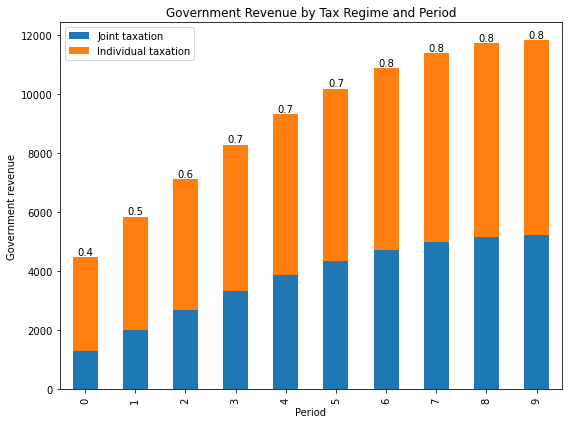

In [33]:
# Create a stacked bar chart
ax = df.plot(kind='bar', stacked=True, figsize=(8,6))

# Add labels and title
ax.set_xlabel('Period')
ax.set_ylabel('Government revenue')
ax.set_title('Government Revenue by Tax Regime and Period')

# Add legends
ax.legend(['Joint taxation', 'Individual taxation'])

# Add the difference values as annotations above the bars
for i, v in enumerate(df['govt_rev_ratio']):
    ax.annotate("{:.1f}".format(v), xy=(i, df.sum(axis=1)[i]), ha='center', va='bottom')

# Save the plot as a figure
fig = ax.get_figure()
fig.tight_layout()
fig.savefig(figpath + r"/no4.pdf", edgecolor='k')

# Question 5
Determine tax_scale_i that provides the same government budget in joint as in individual taxation

In [18]:
# create tax dictory with tax revenue in each tax regime for different values of tax_scale_i
tax_scale_i_vals = np.linspace(1.76, 1.78, 20)

govern_indiv_y = {}

for t_i, tax_scale_i in enumerate(tax_scale_i_vals):
    model6 = model.copy(par={'joint_tax': False,'tax_scale_i': tax_scale_i})
    model6.solve()
    model6.sim.k1_init = 2.0*np.ones(par.simN)
    model6.simulate()

    govern_indiv_y[tax_scale_i] = np.sum(model6.sim.tax_hh,axis=0) 

In [19]:
# Initialize dictionaries to store tax information
govern_indiv_t = {}
diff_y = {}
diff_t = {}

# Loop through each tax scale in the tax_dict
for tax_scale_i in govern_indiv_y.keys():

    govern_indiv_t[tax_scale_i]  = sum(govern_indiv_y[tax_scale_i]) 
    diff_y[tax_scale_i]  = govern_indiv_y[tax_scale_i] - govern_joint_y 
    diff_t[tax_scale_i]  = (govern_indiv_t[tax_scale_i]- govern_joint_t) / 1000

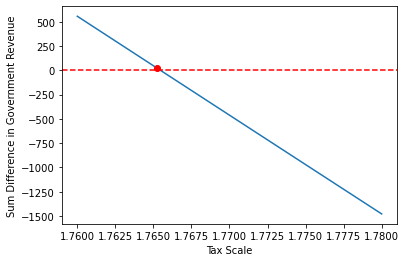

In [34]:
# Plot the mean difference in government revenue for each tax scale
plt.plot(list(diff_t.keys()), list(diff_t.values()))

# Add a red line at y=0
plt.axhline(y=0, color='r', linestyle='--')

# Get the tax scale with the smallest absolute difference in government revenue
best_tax_scale = min(diff_t, key=lambda k: abs(diff_t[k]))

# Get the index of the period with the closest difference to 0
keys_list = list(diff_t.keys())
min_diff_idx = keys_list.index(best_tax_scale)

# Add a red dot at the corresponding point in the plot
plt.plot(best_tax_scale, diff_t[best_tax_scale], 'ro')
        
# Set the x-axis label
plt.xlabel("Tax Scale")

# Set the y-axis label
plt.ylabel("Sum Difference in Government Revenue")

# Save the plot as a figure
plt.savefig(figpath + r"/no5.pdf", edgecolor='k')

# Show the plot
plt.show()

In [21]:
def objective(tax_scale_i):

    par.tax_scale_i = np.array([1.75])
    model8 = model.copy(par={'joint_tax': False,'tax_scale_i': tax_scale_i})
    model8.solve()
    model8.sim.k1_init = 2.0*np.ones(par.simN)
    model8.simulate()

    govern_indiv_y = np.sum(model8.sim.tax_hh,axis=0) 
    govern_indiv_t  = np.sum(govern_indiv_y) # sum over all periods
    diff_y = govern_indiv_y - govern_joint_y  # diff in each period
    diff_t = govern_indiv_t - govern_joint_t # total diff

    print(f"Function value at {tax_scale_i}: {diff_t}")
    return diff_t

lower_bound = 1.75
upper_bound = 1.77

print(f"Lower bound: {lower_bound}")
print(f"Upper bound: {upper_bound}")

root_scalar(objective, bracket=[lower_bound, upper_bound], method='brentq')

Lower bound: 1.75
Upper bound: 1.77
Function value at 1.75: 1577143.8044826663
Function value at 1.77: -461655.598357711
Function value at 1.7654712994548207: -633.0311148259789
Function value at 1.7654650835809227: 0.9577628937549889
Function value at 1.7654650929712032: 1.246500655543059
Function value at 1.7654681962130119: -315.79902301495895
Function value at 1.7654651051719525: -1.5169238345697522
Function value at 1.7654650984746074: -0.5837517031468451
Function value at 1.7654650967193186: 0.8765386687591672
Function value at 1.76546509777293: -0.7795276679098606
Function value at 1.7654650972461243: -1.4260400459170341
Function value at 1.7654650969198613: 1.2590700229629874
Function value at 1.7654650970829928: 0.20466788625344634
Function value at 1.7654650971094106: -1.4137517707422376
Function value at 1.7654650970863337: 0.20531680481508374
Function value at 1.7654650970978722: -1.0065702949650586
Function value at 1.7654650970882886: 0.7648558258078992
Function value at 

      converged: True
           flag: 'converged'
 function_calls: 19
     iterations: 18
           root: 1.7654650970930805

# Question 6

In [22]:
model9 = model.copy(par={'joint_tax': False, 'tax_scale_i': 1.7654689719742316,'q_6': True})
model9.solve()
model9.sim.k1_init = 8.0*np.ones(par.simN)
model9.sim.k2_init = 8.0*np.ones(par.simN)
model9.simulate()
x1 = -model9.sol.V[0,8,8]
print(x1.shape)
print(x1)

()
0.38936747559448714


In [23]:
model10 = model.copy(par={'joint_tax': False, 'tax_scale_i': 1.7654689719742316, 'q_6': True})
model10.solve()
model10.sim.k1_init = 2.0*np.ones(par.simN)
model10.simulate()
y1 = -model10.sol.V[0,0,0]
print(y1.shape)
print(y1)

()
0.46659604898849966


In [24]:
model11 = model.copy(par={'joint_tax': True,'q_6': True})
model11.solve()
model11.sim.k1_init = 8.0*np.ones(par.simN)
model11.sim.k2_init = 8.0*np.ones(par.simN)
model11.simulate()
x2 = -model11.sol.V[0,8,8]
print(x2.shape)
print(x2)

()
0.39067376632052664


In [25]:
model12 = model.copy(par={'joint_tax': True,'q_6': True})
model12.solve()
model12.sim.k1_init = 2.0*np.ones(par.simN)
model12.simulate()
y2 = -model12.sol.V[0,0,0]
print(y2.shape)
print(y2)

()
0.4664638646373709


In [26]:
high_diff = x2 - x1 # joint > individual
print(high_diff)
low_diff = y2 - y1 # individual > joint
print(low_diff)

0.001306290726039494
-0.00013218435112877236


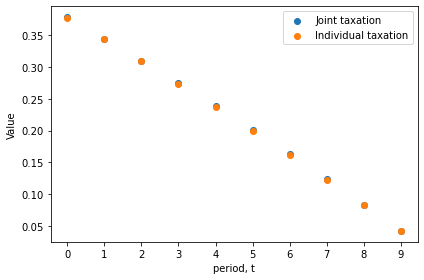

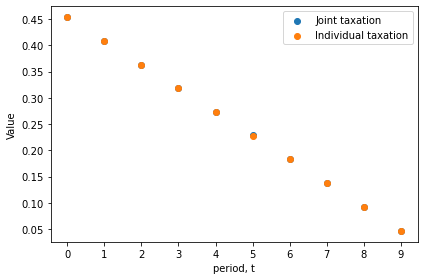

In [35]:
# High human capital 
fig, ax = plt.subplots()
ax.scatter(range(par.simT),-np.mean(getattr(model11.sim,'V'),axis=0),label='Joint taxation')
ax.scatter(range(par.simT),-np.mean(getattr(model9.sim,'V'),axis=0),label='Individual taxation')
ax.set(xlabel='period, t',ylabel=f'Value',xticks=range(par.simT));
ax.legend();
fig.tight_layout()
fig.savefig(figpath + r"/no6h.pdf", edgecolor='k')

# Low human capital 
fig, ax = plt.subplots()
ax.scatter(range(par.simT),-np.mean(getattr(model12.sim,'V'),axis=0),label='Joint taxation')
ax.scatter(range(par.simT),-np.mean(getattr(model10.sim,'V'),axis=0),label='Individual taxation')
ax.set(xlabel='period, t',ylabel=f'Value',xticks=range(par.simT));
ax.legend();
fig.tight_layout()
fig.savefig(figpath + r"/no6l.pdf", edgecolor='k')